## Assess the impact of atmosphere on offset time-seris

Run the following to prepare all time-series datasets in HDF5/MintPy format for this notebook:

```bash
offset_timeseries.py -t ChileSenAT149.txt --plot          # invert range offset, calc SET & ERA5
iono_tec.py timeseriesRg.h5 -g inputs/geometryRadar.h5    # calc IGS TEC
prep_gim_tec.ipynb                                        # calc SUB/GIM TEC
```

In [1]:
%matplotlib inline
import os
import datetime as dt
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt, ticker, gridspec
from mintpy.objects import timeseries
from mintpy.utils import ptime, readfile, utils as ut, plot as pp
from mintpy import tsview
figsize = [12, 3]

# config
n = 3                                 # number of med abs dev
dt_s1ab = dt.datetime(2016, 10, 7)    # dateime separating S1A and S1B
dt2 = dt.datetime(2017, 9, 1)
save = True

# location of interest
win = 9  # size of the window of interest where the median offset is calculated
lalo = [-21.29, -69.58]; box_suffix = 'boxCL'   # box in the center left with low  altitude; box = (10,  55,  20, 70) for SenAT149
lalo = [-21.30, -67.39]; box_suffix = 'boxLR'   # box in the lower right with high altitude; box = (200, 15, 215, 30) for SenAT149

# dir
proj_dir = os.path.expanduser('~/data/geolocation/ChileSenAT149')
#proj_dir = os.path.expanduser('~/data/geolocation/ChileSenDT156')
#proj_dir = os.path.expanduser('~/data/geolocation/KyushuAlos2DT23');  lalo = None; box_suffix = None
proj_name = os.path.basename(proj_dir)

work_dir = os.path.join(proj_dir, 'offset_comp')
if box_suffix is not None:
    work_dir = os.path.join(work_dir, box_suffix)
os.chdir(work_dir)
print('Go to directory', work_dir)

# matplotlib setup
plt.rcParams.update({'font.size': 12})
if proj_name == 'ChileSenDT156':
    plt.rcParams.update({'lines.linewidth': 1.5})
else:
    plt.rcParams.update({'lines.linewidth': 3.0})

Go to directory /Users/yunjunz/data/geolocation/ChileSenAT149/offset_comp/boxLR


### 0. Read all time-series

In [2]:
# data files
geom_file = os.path.join(proj_dir, 'mintpy_offset/inputs/geometryRadar.h5')
mask_file = os.path.join(proj_dir, 'mintpy_offset/maskResInv.h5')
sar_file  = os.path.join(proj_dir, 'mintpy_offset/timeseriesRg.h5')
igs_file  = os.path.join(proj_dir, 'mintpy_offset/inputs/igsTEC.h5')
gim_file  = os.path.join(proj_dir, 'mintpy_offset/inputs/gimTEC.h5')
sub_file  = os.path.join(proj_dir, 'mintpy_offset/inputs/subTEC.h5')
era_file  = os.path.join(proj_dir, 'mintpy_offset/inputs/ERA5.h5')
set_file  = os.path.join(proj_dir, 'mintpy_offset/inputs/SET.h5')

# date info
date_list = timeseries(sar_file).get_date_list()
num_date = len(date_list)

# lalo --> box
if lalo is None:
    box = None
else:
    atr = readfile.read_attribute(sar_file)
    coord = ut.coordinate(atr, lookup_file=geom_file)
    y, x = coord.geo2radar(lalo[0], lalo[1])[:2]
    win2 = int(win/2)
    box = (x-win, y-win, x+win+1, y+win+1)

# read data files into iDict
iDict = {}
fnames = [sar_file, igs_file, gim_file, sub_file, era_file, set_file]
labels = ['SAR'] + [os.path.splitext(os.path.basename(i))[0] for i in fnames[1:]]


for fname, label in zip(fnames, labels):
    if not os.path.isfile(fname):
        next
    else:
        print('read data from file: {}'.format(fname))
        ts_data = readfile.read(fname, box=box)[0].reshape(num_date, -1)
        # mask
        if label == 'SAR':
            ## reference in time
            #ts_data -= np.tile(ts_data[ref_ind, :].reshape(1, -1), (ts_data.shape[0], 1))
            # mask out unreliable SAR offset, including 
            # 1. pixels not inverted, thus with default zero value
            # 2. pixels inverted, but unreliable due to large inversion residual
            mask = readfile.read(mask_file, box=box)[0].flatten()
            ts_data[:, mask==0] = np.nan
        else:
            # mask out invalid pixels
            ts_data[ts_data == 0] = np.nan
        iDict[label] = {}
        iDict[label]['data'] = ts_data
        iDict[label]['med'] = np.nanmedian(ts_data, axis=-1)
        iDict[label]['mad'] = ut.median_abs_deviation(ts_data)

# TEC priority: SUB_TEC > GIM_TEC > IGS_TEC
tec_files = [sub_file, gim_file, igs_file]
tec_file = [i for i in tec_files if os.path.isfile(i)][0]
tec_type = os.path.splitext(os.path.basename(tec_file))[0]
# Files used in the final comparison
fnames = [sar_file, tec_file, set_file, era_file]
labels = ['SAR'] + [os.path.splitext(os.path.basename(i))[0] for i in fnames[1:]]

read data from file: /Users/yunjunz/data/geolocation/ChileSenAT149/mintpy_offset/timeseriesRg.h5
read data from file: /Users/yunjunz/data/geolocation/ChileSenAT149/mintpy_offset/inputs/igsTEC.h5
read data from file: /Users/yunjunz/data/geolocation/ChileSenAT149/mintpy_offset/inputs/gimTEC.h5


/Users/yunjunz/tools/miniconda3/envs/insar/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


read data from file: /Users/yunjunz/data/geolocation/ChileSenAT149/mintpy_offset/inputs/subTEC.h5
read data from file: /Users/yunjunz/data/geolocation/ChileSenAT149/mintpy_offset/inputs/ERA5.h5
read data from file: /Users/yunjunz/data/geolocation/ChileSenAT149/mintpy_offset/inputs/SET.h5


In [3]:
# utils function
def plot_dot_figure(ax, x, y, xname, yname, vlim, vstep=0.2, fbase='offset'):
    # omit nan value
    flag = (~np.isnan(x)) * (~np.isnan(y))
    x = x[flag]
    y = y[flag]

    ax.plot(x, y, 'k.')
    ax.plot(vlim, vlim, 'k--', lw=1)

    # axis format
    ax.xaxis.set_major_locator(ticker.MultipleLocator(vstep))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(vstep))
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_xlim(vlim)
    ax.set_ylim(vlim)
    ax.set_xlabel('${{{b}}}_{{{n}}}$ [m]'.format(b=fbase, n=xname), color='C0')
    ax.set_ylabel('${{{b}}}_{{{n}}}$ [m]'.format(b=fbase, n=yname), color='C1')
    ax.set_aspect('equal', 'box')

    # stats
    rmse = np.sqrt(np.sum((y - x)**2) / (x.size - 1))
    r2 = stats.linregress(y, x)[2]
    msg  = r'$RMSE$ = {:.1f} cm'.format(rmse*100) + '\n'
    msg += r'$R^2$ = {:.2f}'.format(r2) + '\n'
    ax2.annotate(msg, xy=(0.08, 0.65), xycoords='axes fraction', color='k', ha='left')
    #ax2.annotate(msg, xy=(0.95, 0.07), xycoords='axes fraction', color='k', ha='right')

    return

def adjust_ts_axis_format(ax, x, vstep=0.3, xlim=None, ylim=None, label_prefix='cumulative'):
    if xlim is not None:
        ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_ylabel(label_prefix+'\nslant range offset [m]')
    ax.grid('on')
    ax.yaxis.set_major_locator(ticker.MultipleLocator(vstep))
    pp.auto_adjust_xaxis_date(ax, x, every_year=1, buffer_year=None)
    return

### 1. SAR vs. TEC (SUB/GIM/IGS)

RMSE:
  SAR         : 20.30 cm
  SAR - subTEC: 8.60 cm
  SAR - igsTEC: 25.25 cm
save figure to file /Users/yunjunz/data/geolocation/ChileSenAT149/offset_comp/boxLR/TS_SAR_vs_subTEC.png


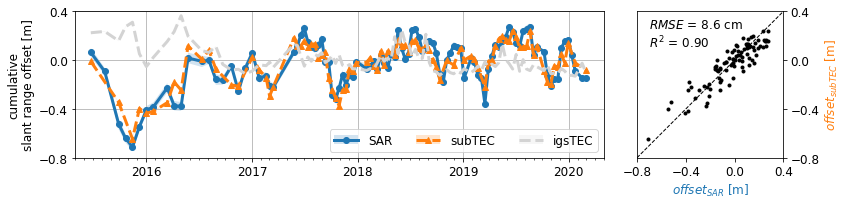

In [4]:
# dset 1: SAR
x1 = ptime.date_list2vector(date_list)[0]
y1  = np.array(iDict['SAR']['med'])
y1e = np.array(iDict['SAR']['mad']) * n

# dset 2: SUB/GIM_TEC
y2  = np.array(iDict[tec_type]['med']) * (-1 if proj_name == 'ChileSenAT149' else 1)
y2e = np.array(iDict[tec_type]['mad']) * n

# dset 3: IGS TEC
# something is strange on the sign of IGS TEC, need to check more carefully.
y3  = np.array(iDict['igsTEC']['med'])
y3e = np.array(iDict['igsTEC']['mad']) * n

# align other data to SAR with a constant
# Notes at 2020-08-25 by ZY: tried use the median difference as yoff, not noticeable difference, thus use the 1st for simplicity
y1 -= np.nanmedian(y1)
y2 -= np.nanmedian(y2 - y1)
y3 -= np.nanmedian(y3 - y1)

# plot - ts figure
fig = plt.figure(figsize=figsize)
gs  = gridspec.GridSpec(3, 12, figure=fig)
ax  = fig.add_subplot(gs[:, 0:-3])
ax2 = fig.add_subplot(gs[:, -3:])
ps = []
for i, (y, ye, c, m, lw) in enumerate(zip([y1, y2, y3], [y1e, y2e, y3e], ['C0', 'C1', 'lightgray'], ['o-', '^--', '--'], [None, 3, 3])):
    flag = ~np.isnan(y)
    y  = np.array(y)[flag]
    ye = np.array(ye)[flag]
    x  = np.array(x1)[flag]
    p0  = ax.fill_between(x, y-ye, y+ye, fc=c, ec='none', alpha=0.2)
    p1, = ax.plot(x, y, m, color=c, ms=6, lw=lw)
    ps.append((p0, p1))
# axis format
if proj_name == 'ChileSenAT149':
    vstep = 0.4; ylim = [-0.8, 0.4]; xlim = [dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1)]
elif proj_name == 'ChileSenDT156':
    vstep = 0.4; ylim = [-0.4, 0.8]; xlim = None
elif proj_name == 'KyushuAlos2DT23':
    vstep = 5;   ylim = [-3, 15]; xlim = None
adjust_ts_axis_format(ax, x=x1, vstep=vstep, xlim=xlim, ylim=ylim)
ax.legend(handles=ps, labels=['SAR', tec_type, 'igsTEC'], loc='best', ncol=len(ps))

# plot - dot figure
plot_dot_figure(ax2, x=y1, y=y2, xname='SAR', yname=tec_type, vlim=ylim, vstep=vstep)
fig.tight_layout()

# RMSE
print('RMSE:')
rmse = ut.root_mean_sq_error(y1);     print('  SAR         : {:.2f} cm'.format(rmse*100))
rmse = ut.root_mean_sq_error(y1, y2); print('  SAR - {}: {:.2f} cm'.format(tec_type, rmse*100))
rmse = ut.root_mean_sq_error(y1, y3); print('  SAR - igsTEC: {:.2f} cm'.format(rmse*100))

# output
out_fig = os.path.join(work_dir, 'TS_SAR_vs_{}.png'.format(tec_type))
print('save figure to file', out_fig)
if save:
    plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

## check the sign convention again!

### 2. SAR - TEC vs. SET

save figure to file /Users/yunjunz/data/geolocation/KyushuAlos2DT23/offset_comp/TS_SAR_gimTEC_vs_SET.png


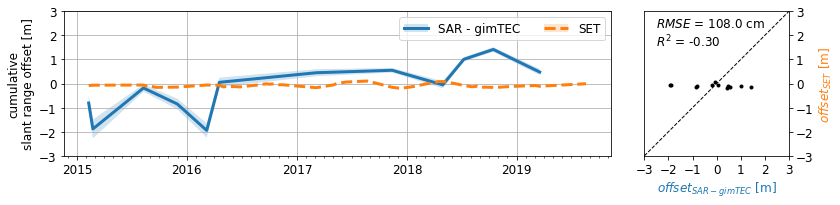

In [34]:
tec_type = 'gimTEC'

# dset 1: SAR - TEC
x1 = ptime.date_list2vector(date_list)[0]
y1  = np.array(iDict['SAR']['med'])
y1 -= np.array(iDict[tec_type]['med']) * (-1 if proj_name == 'ChileSenAT149' else 1)
y1e = (iDict['SAR']['mad']**2 + iDict[tec_type]['mad']**2) ** 0.5 * n

# dset 2: SET
y2  = np.array(iDict['SET']['med'])
y2e = np.array(iDict['SET']['mad']) * n

# align all data with a constant
y1 -= np.nanmedian(y1)
y2 -= np.nanmedian(y2 - y1)

# plot - ts figure
fig = plt.figure(figsize=figsize)
gs  = gridspec.GridSpec(3, 12, figure=fig)
ax  = fig.add_subplot(gs[:, 0:-3])
ax2 = fig.add_subplot(gs[:, -3:])
ps = []
for i, (y, ye, c, m) in enumerate(zip([y1, y2], [y1e, y2e], ['C0', 'C1'], ['-', '--'])):
    flag = ~np.isnan(y)
    y  = np.array(y)[flag]
    ye = np.array(ye)[flag]
    x  = np.array(x1)[flag]
    p0  = ax.fill_between(x, y-ye, y+ye, fc=c, ec='none', alpha=0.2)
    p1, = ax.plot(x, y, m, color=c, ms=6)
    ps.append((p0, p1))
# axis format
xname = 'SAR - {}'.format(tec_type)
ax.legend(labels=[xname, 'SET'], handles=ps, loc='best', ncol=len(ps))
if proj_name == 'ChileSenAT149':
    vstep = 0.3; ylim = [-0.3, 0.3]; xlim = [dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1)]
elif proj_name == 'ChileSenDT156':
    vstep = 0.3; ylim = [-0.5, 0.5]; xlim = None
elif proj_name == 'KyushuAlos2DT23':
    vstep = 1;   ylim = [-3, 3];     xlim = None
adjust_ts_axis_format(ax, x=x1, vstep=vstep, xlim=xlim, ylim=ylim)

# plot - dot figure
plot_dot_figure(ax2, x=y1, y=y2, xname=xname, yname='SET', vlim=ylim, vstep=vstep)
fig.tight_layout()

# output
out_fig = os.path.join(work_dir, 'TS_SAR_{}_vs_SET.png'.format(tec_type))
print('save figure to file', out_fig)
if save:
    plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### 3. SAR - TEC - SET vs. ERA5

save figure to file /Users/yunjunz/data/geolocation/KyushuAlos2DT23/offset_comp/TS_SAR_gimTEC_SET_vs_ERA5.png


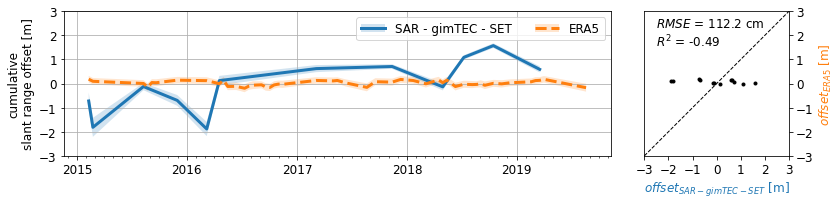

In [35]:
# dset 1: SAR - TEC
x1 = ptime.date_list2vector(date_list)[0]
y1  = np.array(iDict['SAR']['med'])
y1 -= np.array(iDict[tec_type]['med']) * (-1 if proj_name == 'ChileSenAT149' else 1)
y1 -= np.array(iDict['SET']['med'])
y1e = (iDict['SAR']['mad']**2 + iDict[tec_type]['mad']**2 + iDict['SET']['mad']**2) ** 0.5 * n

# dset 2: ERA5
y2  = np.array(iDict['ERA5']['med'])
y2e = np.array(iDict['ERA5']['mad']) * n

# align all data with a constant
y1 -= np.nanmedian(y1)
y2 -= np.nanmedian(y2 - y1)

# plot - ts figure
fig = plt.figure(figsize=(12, 3))
gs  = gridspec.GridSpec(3, 12, figure=fig)
ax  = fig.add_subplot(gs[:, 0:-3])
ax2 = fig.add_subplot(gs[:, -3:])
ps = []
for i, (y, ye, c, m) in enumerate(zip([y1, y2], [y1e, y2e], ['C0', 'C1'], ['-', '--'])):
    flag = ~np.isnan(y)
    y  = np.array(y)[flag]
    ye = np.array(ye)[flag]
    x  = np.array(x1)[flag]
    p0  = ax.fill_between(x, y-ye, y+ye, fc=c, ec='none', alpha=0.2)
    p1, = ax.plot(x, y, m, color=c, ms=6)
    ps.append((p0, p1))
# axis format
xname = 'SAR - {} - SET'.format(tec_type)
ax.legend(labels=[xname, 'ERA5'], handles=ps, loc='best', ncol=len(ps))
if proj_name == 'ChileSenAT149':
    vstep = 0.3; ylim = [-0.3, 0.3]; xlim = [dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1)]
elif proj_name == 'ChileSenDT156':
    vstep = 0.3; ylim = [-0.5, 0.5]; xlim = None
elif proj_name == 'KyushuAlos2DT23':
    vstep = 1;   ylim = [-3, 3];     xlim = None
adjust_ts_axis_format(ax, x=x1, vstep=vstep, xlim=xlim, ylim=ylim)

# plot - dot figure
plot_dot_figure(ax2, x=y1, y=y2, xname=xname, yname='ERA5', vlim=ylim, vstep=vstep)
fig.tight_layout()

# output
out_fig = os.path.join(work_dir, 'TS_SAR_{}_SET_vs_ERA5.png'.format(tec_type))
print('save figure to file', out_fig)
if save:
    plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

## RMSE after anomaly

In [16]:
## RMSE after anomaly
flag = x > dt2
rmse = np.sqrt(np.nansum((y2[flag] - y1[flag])**2) / (np.nansum(flag) - 1))
print('RMSE after {}: {:.2f} cm'.format(dt2.date(), rmse*100))

RMSE after 2017-09-01: 45.58 cm


## Apply noise reductions: TEC, SET and ERA5

In [8]:
os.chdir(os.path.join(proj_dir, 'mintpy_offset'));  print('Go to directory:', os.path.join(proj_dir, 'mintpy_offset'))

# noise reduction
if proj_name == 'ChileSenAT149':
    !add.py  timeseriesRg.h5            inputs/subTEC.h5 -o timeseriesRg_subTEC.h5
    !reference_date.py timeseriesRg_subTEC.h5 -t ChileSenAT149.txt --force
    !diff.py timeseriesRg_subTEC.h5     inputs/SET.h5    -o timeseriesRg_subTEC_SET.h5
    !diff.py timeseriesRg_subTEC_SET.h5 inputs/ERA5.h5   -o timeseriesRg_subTEC_SET_ERA5.h5

elif proj_name == 'ChileSenDT156':
    !diff.py timeseriesRg.h5            inputs/gimTEC.h5 -o timeseriesRg_gimTEC.h5
    !diff.py timeseriesRg_gimTEC.h5     inputs/SET.h5    -o timeseriesRg_gimTEC_SET.h5
    !diff.py timeseriesRg_gimTEC_SET.h5 inputs/ERA5.h5   -o timeseriesRg_gimTEC_SET_ERA5.h5

os.chdir(work_dir);  print('Go to directory:', work_dir)

Go to directory: /Users/yunjunz/data/geolocation/ChileSenAT149/mintpy_offset
setenv: Variable name must contain alphanumeric characters.
input files to be added: (2)
['timeseriesRg.h5', 'inputs/subTEC.h5']
adding timeseries ...
use metadata from the 1st file: timeseriesRg.h5
delete exsited file: timeseriesRg_subTEC.h5
create HDF5 file: timeseriesRg_subTEC.h5 with w mode
create dataset /timeseries of float32    in size of (104, 123, 231)      with compression=None
create dataset /bperp      of float32    in size of (104,)     with compression=None
create dataset /date       of |S8        in size of (104,)     with compression=None
finished writing to timeseriesRg_subTEC.h5
Done.
setenv: Variable name must contain alphanumeric characters.
input reference date: 20200123
--------------------------------------------------
change reference date for file: /Users/yunjunz/data/geolocation/ChileSenAT149/mintpy_offset/timeseriesRg_subTEC.h5
reading data ...
referencing in time ...
---------------

## Plot residual time-series for POI

Go to directory: /Users/yunjunz/data/geolocation/ChileSenDT156/mintpy_offset
tsview.py timeseriesRg_gimTEC_SET_ERA5.h5 --ex S1B_date.txt --noverbose --save --figsize 8 3 --lalo -21.3 -67.39


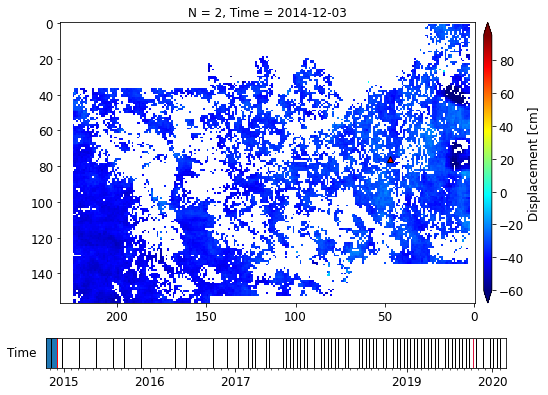

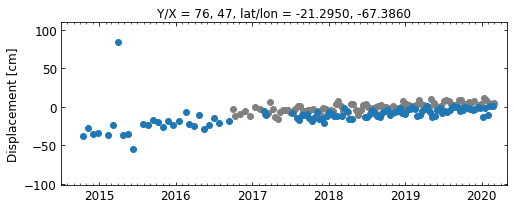

Go to directory: /Users/yunjunz/data/geolocation/ChileSenAT149/offset_comp/boxLR


In [21]:
#proj_dir = os.path.expanduser('~/data/geolocation/ChileSenAT149')
proj_dir = os.path.expanduser('~/data/geolocation/ChileSenDT156')
proj_name = os.path.basename(proj_dir)
os.chdir(os.path.join(proj_dir, 'mintpy_offset'));  print('Go to directory:', os.path.join(proj_dir, 'mintpy_offset'))

if proj_name == 'ChileSenAT149':
    ts_file = 'timeseriesRg_subTEC_SET_ERA5.h5'
elif proj_name == 'ChileSenDT156':
    ts_file = 'timeseriesRg_gimTEC_SET_ERA5.h5'

iargs = [ts_file, '--ex', 'S1B_date.txt', '--noverbose', '--save', '--figsize', '8', '3', '--lalo', str(lalo[0]), str(lalo[1])]
tsview.main(iargs)

os.chdir(work_dir);  print('Go to directory:', work_dir)

## Differential TS: (SAR - subTEC - ERA5) vs. SET

save figure to file /Users/yunjunz/data/geolocation/ChileSenAT149/offset_comp/boxLR/DIFF_TS_SAR_subTEC_ERA5_vs_SET.png


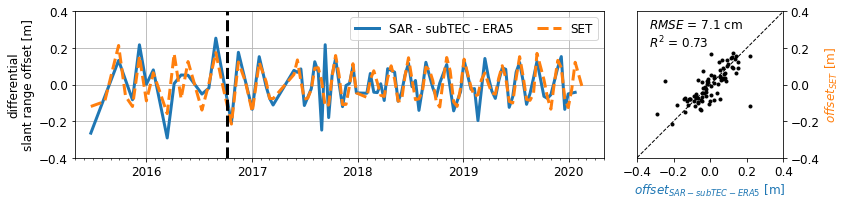

In [20]:
# dset 1: SAR - TEC
x1 = ptime.date_list2vector(date_list)[0]
y1  = np.array(iDict['SAR']['med'])
y1 -= np.array(iDict[tec_type]['med']) * (-1 if proj_name == 'ChileSenAT149' else 1)
y1 -= np.array(iDict['ERA5']['med'])

# dset 2: SET
y2  = np.array(iDict['SET']['med'])

# align all data with a constant
y1 -= np.nanmedian(y1)
y2 -= np.nanmedian(y2 - y1)

# plot - ts figure
fig = plt.figure(figsize=figsize)
gs  = gridspec.GridSpec(3, 12, figure=fig)
ax  = fig.add_subplot(gs[:, 0:-3])
ax2 = fig.add_subplot(gs[:, -3:])
ps = []
for i, (y, c, m) in enumerate(zip([y1, y2], ['C0', 'C1'], ['-', '--'])):
    flag = ~np.isnan(y)
    y  = np.array(y)[flag]
    x  = np.array(x1)[flag]
    p1, = ax.plot(x[:-1], np.diff(y), m, color=c, ms=6)
    ps.append((p1))
# axis format
ax.axvline(x=dt_s1ab, linestyle='--', color='k')   # S1A / S1B
xname = 'SAR - {} - ERA5'.format(tec_type)
ax.legend(labels=[xname, 'SET'], handles=ps, loc='best', ncol=len(ps))
if proj_name == 'ChileSenAT149':
    vstep = 0.2; ylim = [-0.4, 0.4]; xlim = [dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1)]
elif proj_name == 'ChileSenDT156':
    vstep = 0.3; ylim = [-0.5, 0.5]; xlim = None
adjust_ts_axis_format(ax, x=x1, vstep=vstep, xlim=xlim, ylim=ylim, label_prefix='differential')

# plot - dot figure
plot_dot_figure(ax2, x=np.diff(y1), y=np.diff(y2), xname=xname, yname='SET', vlim=ylim, vstep=vstep)
fig.tight_layout()

# output
out_fig = os.path.join(work_dir, 'DIFF_TS_SAR_{}_ERA5_vs_SET.png'.format(tec_type))
print('save figure to file', out_fig)
if save:
    plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()